# Módulo 1: Análisis de datos en el ecosistema Python

### Sesión (11)

**21/11/2022**

## Aplicar un caso de uso (*Regresión*)

In [ ]:
# importamos las librerías necesarias 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
# Modificamos los parámetros de los gráficos en matplotlib
from matplotlib.pyplot import rcParams

rcParams['figure.figsize'] = 12, 6 # el primer dígito es el ancho y el segundo el alto
rcParams["font.weight"] = "bold"
rcParams["font.size"] = 10
rcParams["axes.labelweight"] = "bold"

### **1- Análisis y filtrado de datos**

### Dataset: [**California Housing**](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)

Este conjunto de datos se ha obtenido desde el repositorio de [StatLib](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) y está disponible en los recursos de la librería *scikit-learn*. Se puede descargar utilizando la función *sklearn.datasets.fetch_california_housing()*.

La variable objetivo es **el valor medio de la vivienda para los distritos de *California***, expresado en cientos de miles de dólares (*100,000 $*).

Este conjunto de datos se derivó del censo estadounidense de 1990, utilizando **una fila por grupo de bloques de censo**. Un grupo de bloques es la unidad geográfica más pequeña para la cual la ***Oficina del Censo de EE. UU.*** publica datos de muestra (un grupo de bloques generalmente tiene una población entre 600 y 3,000 personas).

Una vivienda o un hogar es un grupo de personas que residen dentro de una casa. Dado que se proporcionan el número promedio de habitaciones y dormitorios en este conjunto de datos por hogar, estas columnas pueden tomar valores sorprendentemente grandes para grupos de bloques con pocos hogares y muchas casas vacías, como resorts turísticas y vacacionales.

In [ ]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

# Convertir los datos en pandas dataframe
dataframe_x = pd.DataFrame(california.data, columns = california.feature_names)

# La variable dependiente es el target y la llamammos dataframe_y
dataframe_y = pd.DataFrame(california.target, columns = ['target'])

# Combinamos ambos para obtener un dataframe con todas las variables explicativas y la variable objetivo
df_california = dataframe_x.join(dataframe_y)

df_california

Las variables que componen este dataset son:

- **MedInc**: Ingresos medios en el grupo de bloques.  

- **HouseAge**: Media de la antigüedad de las casas en el grupo de bloques.  

- **AveRooms**: Número promedio de habitaciones/cuartos por hogar.  

- **AveBedrms**: Número promedio de dormitorios por hogar.  

- **Population**: Población del grupo de bloques.  

- **AveOccup**: Número promedio de miembros del hogar.  

- **Latitude**: Latitud del grupo de bloques.  

- **Longitude**: Longitud del grupo de bloques. 

In [ ]:
# Información del Dataframe descargado
df_california.info()

In [ ]:
# Consultamos las principales estadísticas del conjunto de datos
df_california.describe()

La información del Dtaframe indica que no hay valores perdido. Aún así lo podemos comprobar a nivel de cada columna para asegurarnos:

In [ ]:
df_california.isna().sum()

Echamos un vistazo a la distribución de cada variable mediante diagrama de cajas.

In [ ]:
sns.boxplot(data=df_california,  orient='v')

Lo primero que podemos observar son los **valores muy diversos** que puede tomar la variable ***Population***

In [ ]:
# Visualizamos la distribución de los valores mediante el histograma
sns.histplot(df_california['Population'])

In [ ]:
# Visualizamos el diagrama de caja para marcar los cuartiles y detectar los valores atípicos
sns.boxplot(data=df_california['Population'],  orient='v')

Además de contener valores que toman un rango amplio, se puede observar que existen una serie de **valores muy lejos de la distribución principal que elevan considerablemente la dispersión** de esta variable.  

Filtramos primero los valores que se consideran **atípicos (outliers) en la representación de *boxplot* según la distancia intercuartil**.

In [ ]:
# Filtrar los valores atípicos basado en el rango intercuartil
Q1 = df_california['Population'].quantile(0.25)
Q3 = df_california['Population'].quantile(0.75)

# IQR es el rango intercuartil 
IQR = Q3 - Q1    

# Limites permitidos para los datos
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 *IQR

# Crear la máscara
filtro_oulier = (df_california['Population'] < lim_inf) | (df_california['Population'] > lim_sup)

# Filtramos el dataset aplicando la máscara
df_pop_out = df_california[filtro_oulier] 
df_pop_out

In [ ]:
# Calculamos el porcentaje que componen estos valores respecto a la totalidad de los datos
df_pop_out.shape[0]/df_california.shape[0] * 100

Se puede ver que estos datos **componen más de 5% de todos los registros que tenemos disponible** en el dataset original. Esto aumenta el peligro de pérdidad de información a la hora de generar un modelo que tiene que ser suficientemente enriquecido y genérico para poder predecir los precios de las viviendas en todos los distritos.

In [ ]:
# Consultamos las principales estadísticas de los datos a filtrar
df_pop_out.describe()

In [ ]:
# Visualizar la distribución de los datos mediante el histograma
sns.histplot(df_pop_out['Population'])

Se observa que los datos filtrados todavía contienen una serie de valores más concentrados que otros.

In [ ]:
sns.boxplot(data=df_pop_out['Population'].reset_index().drop('index', axis='columns'),  orient='v')

Antes de seguir analizando los valores de las variables del dataset, revisamos las relaciones que puede haber directamente entre cada variable de nuestro dataset.  

In [ ]:
# Visualizamos las relaciones de cada par de variables existentes en el conjunto de datos
sns.pairplot(data=df_california, height=3)
plt.show()

Podemos también calcular la correlación por pares de columnas y visualizar los coeficientes correspondientes de cada par de variables: 

In [ ]:
df_corr = df_california.corr()
df_corr

In [ ]:
plt.figure(figsize = (16,8))
sns.heatmap(df_corr, cmap='Blues', annot = True)

In [ ]:
# Filtramos las variable con menos correlación con la variable objetivo:
df_corr[df_corr['target'].abs() < 0.05]

- **Population** aparece como una de las variables con menos correlación con la variable de salida o ***target***. No parece que tenga mucha relación con el resto salvo con **HouseAge** y quizá la variable **AveOccup** que podría acoger la información ocupacional de una zona y aportar algo más directamente relacionado con el precio de una vivienda.

  Además, esta variable **por sus valores dispersos y el hecho de ser una variable cruda (no promediada) podría causarnos más problemas** más adelante a la hora de construir un modelo de regresión que añadir un valor predictivo, con lo cual procedemos a eliminarla.
  
- **AveBedrms** tiene una correlación muy baja con la variable objetivo cuando **AveRooms** tiene algo de relación. En realidad podemos pensar que **una variable que represente el concepto de número de cuartos en una vivienda debería de ser suficiente** para considerar este concepto en el modelo. El **AveBedrms** no tiene prácticamente ninguna relación con otras variables salvo el **AveRooms**, cuando ésta última tiene alguna correlación tanto con **target** como la variable **MedInc** y por lo tanto podemos quitar esta variable y eleminar una información menos relevante y posiblemente redundante.  

- Las variable geográficas de **Longitude** y **Latitud** puede que tengan muy poca correlación por separado con la varieble objetivo. Sin embargo, cuando se representan conjuntamente se puede ver que tienen una relación considerable con los precios de las viviendas Californianas. 

In [ ]:
# Diagrama Scatterplot pintado en base a los precios de viviendas (la variable "target")
plt.figure(figsize = (10,10))
sns.scatterplot(x=df_california['Longitude'], y=df_california['Latitude'], hue=df_california['target'])
plt.show()

Efectivamente hay una relación entre los puntos que se forman con pares de valores de estas dos variables y el precio de vivinedas. Básicamente **cada punto representa una posición geográfica en California**, en otras palabras tenemos pintado la ubicación de los grupos de bloques de viviendas presentes en nuestro dataset. A continuación vemos **una mapa censal del estado de California**: 

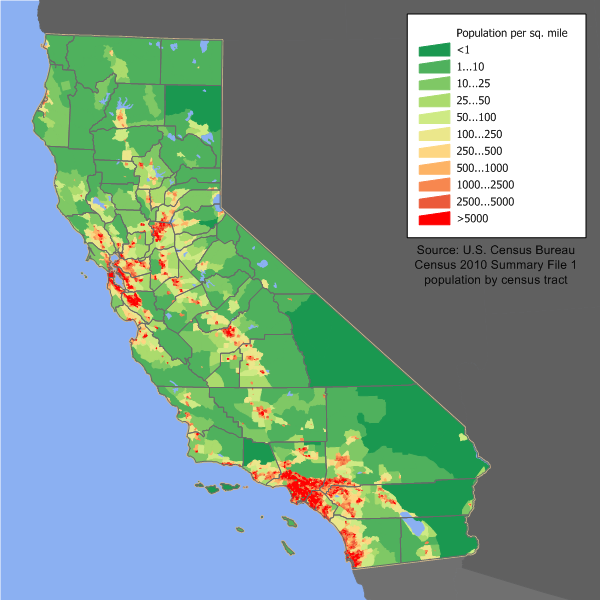

Filtramos el dataset quitando las dos columnas mencionadas anteriormente.

In [ ]:
df_california_filt = df_california.drop(labels=['Population', 'AveBedrms'], axis='columns')
df_california_filt

In [ ]:
# Visualizar el diagrama de cajas
sns.boxplot(data=df_california_filt,  orient='v')

Se observa que el conjunto de datos filtrados tiene menos dispersión en general salvo algunas de las variables. Las variables que pueden contener valores atípicos serían:
- **AveRooms**
- **AveOccup**

Vamos a revisar los valores presentes en la variable ***AveRooms***:

In [ ]:
sns.boxplot(data=df_california_filt['AveRooms'],  orient='v')

In [ ]:
sns.histplot(df_california_filt['AveRooms'])

In [ ]:
# Filtrar los valores atípicos basado en el rango intercuartil
Q1 = df_california_filt['AveRooms'].quantile(0.25)
Q3 = df_california_filt['AveRooms'].quantile(0.75)

# IQR es el rango intercuartil 
IQR = Q3 - Q1    

# Limites permitidos para los datos
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 *IQR

# Crear la máscara
filtro_oulier = (df_california_filt['AveRooms'] < lim_inf) | (df_california_filt['AveRooms'] > lim_sup)

# Filtramos el dataset aplicando la máscara
df_room_out = df_california_filt[filtro_oulier] 
df_room_out

In [ ]:
# El porcentaje que componen estos valores del todo el dataset
df_room_out.shape[0]/df_california.shape[0] * 100

El porcentaje de datos a filtrar se puede considerar algo elevado. A continuación vemos la distribución de los valores que se han detectado:

In [ ]:
df_room_out.describe()

In [ ]:
sns.histplot(df_room_out['AveRooms'])

Se observa alguna concentración todavía esn estos datos. Igualmente procedemos a detactar los valores que se consideran atípicos (outliers) entre este conjunto de datos.

In [ ]:
sns.boxplot(data=df_room_out['AveRooms'].reset_index().drop('index', axis='columns'), orient='V')

In [ ]:
# Filtrar los valores atípicos basado en el rango intercuartil
Q1 = df_room_out['AveRooms'].quantile(0.25)
Q3 = df_room_out['AveRooms'].quantile(0.75)

# IQR es el rango intercuartil 
IQR = Q3 - Q1    

# Limites permitidos para los datos 
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 *IQR

# Crear la máscara
filtro_oulier = (df_room_out['AveRooms'] < lim_inf) | (df_room_out['AveRooms'] > lim_sup)

# Filtramos el dataset aplicando la máscara
df_room_outliers = df_room_out[filtro_oulier] 
df_room_outliers

In [ ]:
# El porcentaje que componen estos valores de todo el dataset
df_room_outliers.shape[0]/df_california.shape[0] * 100

Esta vez el porcentaje de datos a filtrar no parece preocupante para hacernos perder una parte de la información que contiene el dataset.

In [ ]:
df_room_outliers.describe()

In [ ]:
sns.histplot(df_room_outliers['AveRooms'])

Ahora sí que los valores a filtrar tienen pinta de ser valores bastante dsipersos con una desviación importante. Como el porcentaje de estos datos no es elevado podemos proceder a aliminarlos y de esta manera filtrar otra vez el conjunto de datos.

In [ ]:
df_california_filt.drop(index=df_room_outliers.index).reset_index(drop=True)

In [ ]:
# Comprobamos el tamaño del dataset filtrado por si acaso
df_california_filt.shape[0] - df_room_outliers.shape[0]

In [ ]:
# Filtramos el dataset, eliminando estos registros identificados como outliers
df_california_filt2 = df_california_filt.drop(index=df_room_outliers.index).reset_index(drop=True)
df_california_filt2

In [ ]:
# Revisamos las características del nuevo dataset recién filtrado
df_california_filt2.describe()

In [ ]:
sns.boxplot(data=df_california_filt2,  orient='v')

Ahora repasamos el conenido de la variable ***AveOccup*** con posibles outliers.

In [ ]:
sns.boxplot(data=df_california_filt2['AveOccup'],  orient='v')

In [ ]:
sns.histplot(df_california_filt2['AveOccup'])

In [ ]:
# Filtrar los valores atípicos basado en el rango intercuartil
Q1 = df_california_filt2['AveOccup'].quantile(0.25)
Q3 = df_california_filt2['AveOccup'].quantile(0.75)

# IQR es el rango intercuartil 
IQR = Q3 - Q1    

# Limites permitidos para los datos
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 *IQR

# Crear la máscara
filtro_oulier = (df_california_filt2['AveOccup'] < lim_inf) | (df_california_filt2['AveOccup'] > lim_sup)

# Filtramos el dataset aplicando la máscara
df_ocup_out = df_california_filt2[filtro_oulier] 
df_ocup_out

In [ ]:
# El porcentaje que componen estos valores de todo el dataset
df_ocup_out.shape[0]/df_california.shape[0] * 100

Otra vez el porcentaje de los datos a eliminar es algo difícil de ignorar. Consultamos las estadísticas de estos valores.

In [ ]:
df_ocup_out.describe()

In [ ]:
sns.histplot(df_ocup_out['AveOccup'])

Se observa que los datos detectados como valores atípicos contienen todavía alguna concentración, por lo tanto vamos a intentar a identificar los valores atípicos dentro de este conjunto.

In [ ]:
sns.boxplot(data=df_ocup_out['AveOccup'].reset_index().drop('index', axis='columns'), orient='V')

In [ ]:
# Filtrar los valores atípicos basada en el rango intercuartil
Q1 = df_ocup_out['AveOccup'].quantile(0.25)
Q3 = df_ocup_out['AveOccup'].quantile(0.75)

# IQR es el rango intercuartil 
IQR = Q3 - Q1    

# Limites permitidos para los datos
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 *IQR

# Crear la máscara
filtro_oulier = (df_ocup_out['AveOccup'] < lim_inf) | (df_ocup_out['AveOccup'] > lim_sup)

# Filtramos el dataset aplicando la máscara
df_ocup_outliers = df_ocup_out[filtro_oulier] 
df_ocup_outliers

In [ ]:
# El porcentaje que componen estos valores de todo el dataset
df_ocup_outliers.shape[0]/df_california.shape[0] * 100

In [ ]:
df_ocup_outliers.describe()

In [ ]:
sns.histplot(df_ocup_outliers['AveOccup'])

Como estos valores son muy dispersos y además forman un porcentaje muy pequeño respecto a todos los datos del dataset original, procedemos a eliminarlos.

In [ ]:
df_california_filt2.drop(index=df_ocup_outliers.index).reset_index(drop=True)

In [ ]:
# Comprobamos el tamaño de los datos resultantes
df_california_filt2.shape[0] - df_ocup_outliers.shape[0]

In [ ]:
df_california_filt3 = df_california_filt2.drop(index=df_ocup_outliers.index).reset_index(drop=True)
df_california_filt3

In [ ]:
df_california_filt3.describe()

In [ ]:
sns.boxplot(data=df_california_filt3,  orient='v')

Comprobamos el porcentaje de los registros del dataset que se ha obtenido finalmente aplicando todos los filtros anteriores: 

In [ ]:
df_california_filt3.shape[0] / df_california.shape[0] * 100

Volvemos a investigar las relaciones entre los pares de variables, esta vez con los datos filtrados.

In [ ]:
sns.pairplot(data=df_california_filt3, height=3)
plt.show()

Se observa que por la eliminación de los valores considerablemente atípicos, los diagramas de dispersión visualizan mejor las relaciones de cada conjunto de variables presentes en el dataset.

In [ ]:
plt.figure(figsize = (16,8))
sns.heatmap(df_california_filt3.corr(), cmap='Blues', annot = True)

---

### **2-Creación de modelos** 

In [ ]:
# Definimos los conjuntos de variables de entrada y la variable de salida
X_multiple = df_california_filt3.drop(['target'], axis='columns')
y_multiple = df_california_filt3['target']

In [ ]:
# Dividir el dataset en Training y Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_multiple, y_multiple, test_size=0.2, random_state=222)

### Regresión lineal múltiple

### **`Ejercicio 11.1`**

Vamos a realizar el primer modelo de regresión:

**`11.1.1`** Construye como ejercicios anteriores en este bloque, un modelo de *Regresión lineal múltiple* para este conjunto de variables de entrada y la variable de salida.
   
**`11.1.2`** Consulta y visualiza los coeficientes del modelo ajustado.  

**`11.1.3`** Calcula diferentes métricas para evaluar tu modelo y explica si este modelo tiene un rendimiendo aceptable:  
- MAE
- MAPE
- MSE
- RMSE
- $R^2$

In [ ]:
## Solución
# Ejercicio 11.1.1

In [ ]:
## Solución
# Ejercicio 11.1.2

In [ ]:
## Solución
# Ejercicio 11.1.3

### Ridge (L2) regression

### **`Ejercicio 11.2`**

Vamos a realizar otro tipo de modelo de regresión:

**`11.2.1`** Construye como ejercicios anteriores en este bloque, un modelo de *Regresión con la penalización tipo Ridge (L2)* para este conjunto de variables de entrada y la variable de salida. (poniendo `alpha = 1, random_state=100`)
   
**`11.2.2`** Consulta y visualiza y compara como los ejercicios anteriores de este bloque los coeficientes del modelo ajustado.  

**`11.2.3`** Calcula diferentes métricas para evaluar tu modelo y explica si este modelo tiene un rendimiendo aceptable en comparación con el modelo anterior:  
  
- MAE
- MAPE
- MSE
- RMSE
- $R^2$



In [ ]:
## Solución
# Ejercicio 11.2.1


In [ ]:
## Solución
# Ejercicio 11.2.2


In [ ]:
## Solución
# Ejercicio 11.2.3


### Lasso (L1) regression

### **`Ejercicio 11.3`**

Vamos a realizar otro tipo de modelo de regresión:

**`11.3.1`** Construye como ejercicios anteriores en este bloque, un modelo de *Regresión con la penalización tipo Lasso (L1)* para este conjunto de variables de entrada y la variable de salida. (poniendo `alpha = 1, random_state=100`)
   
**`11.3.2`** Consulta y visualiza y compara como los ejercicios anteriores de este bloque los coeficientes del modelo ajustado.  

**`11.3.3`** Calcula diferentes métricas para evaluar tu modelo y explica si este modelo tiene un rendimiendo aceptable en comparación con los modelos anteriores:  
  
- MAE
- MAPE
- MSE
- RMSE
- $R^2$



In [ ]:
## Solución
# Ejercicio 11.3.1


In [ ]:
## Solución
# Ejercicio 11.3.2

In [ ]:
## Solución
# Ejercicio 11.3.3


### Elastic Net regression

### **`Ejercicio 11.4`**

Vamos a realizar otro tipo de modelo de regresión:

**`11.4.1`** Construye como ejercicios anteriores en este bloque, un modelo de *Regresión combinando las penalizaciones mediante Elastic Net* para este conjunto de variables de entrada y la variable de salida. (poniendo `alpha=1, l1_ratio=0.2, random_state=100`)
   
**`11.4.2`** Consulta y visualiza y compara como los ejercicios anteriores de este bloque los coeficientes del modelo ajustado.  

**`11.4.3`** Calcula diferentes métricas para evaluar tu modelo y explica si este modelo tiene un rendimiendo aceptable en comparación con los modelos anteriores:  
  
- MAE
- MAPE
- MSE
- RMSE
- $R^2$



In [ ]:
## Solución
# Ejercicio 11.4.1

In [ ]:
## Solución
# Ejercicio 11.4.2


In [ ]:
## Solución
# Ejercicio 11.4.3


### **`Ejercicio 11.5`**

Realiza una busqueda en estos rangos indicados con el método `ElasticNetCV` y resuelve los siguientes puntos:

- $\alpha$:  valores entre `0.6` y `5` con pasos de una centésima.
- $l1_{ratio}$:  valores entre este listado: `[.1, .2, .3, .4, .5, .7, .9, .95, .99, 1]` 
- para `KFold` poner >>> `n_splits=10` y `random_state=111`  
- para `ElasticNetCV` poner >>> `random_state=100`

**`11.5.1`** Entrena un modelo tipo regresión lineal múltiple con los hiperparámetros resultantes y sca las predicciones correspondientes al conjunto de datos de prueba.  

**`11.5.2`** Visualiza los coeficientes del modelo y comparalos con los coeficientes correspondientes al modelo original (primer modelo sin regularización).  

**`11.5.3`** Calcula diferentes métricas para evaluar tu modelo y analiza su rendimiendo en comparación con modelos anteriores.
- MAE
- MAPE
- MSE
- RMSE
- $R^2$  

In [ ]:
## Solución
# Ejercicio 11.5.1


In [ ]:
## Solución
# Ejercicio 11.5.2


In [ ]:
## Solución
# Ejercicio 11.5.3


---

### Decision Trees

### **`Ejercicio 11.6`**

**`11.6.1`** Saca la gráfica de *Model Complexity Curve* que dibuja la evolución de R_cuadrado de training versus del test para el rango de profundidades entre `2` y `20` **no inclusive** indicando `random_state=100.

**`11.6.2`** Realiza una búsqueda del valor de hiperparámetro y el modelo óptimo usando la técnica de *Grid Search* para dicho rango de profundidades y compáralo con el valor sugerido del paso anterior.  
- para `KFold`  >>> `n_splits=10` y `random_state=111`  
- para `GridSearchCV`  >>> `random_state=100`  

**`11.6.3`** Calcula diferentes métricas para evaluar tu modelo y analiza su rendimiendo en comparación con modelos anteriores.
- MAE
- MAPE
- MSE
- RMSE
- $R^2$    

**`11.6.4`** Define una función que coja la profundidad máxima para un árbol y dibuje el *Learning Curve* que visualiza la evolución del rendimiento del modelo tanto en training como en test, en función del tamaño de subconjuntos de datos de entrenamiento que se aumentan desde `20` puntos **de 10 en 10** hasta considerar todos los datos de training.

**`11.6.5`** Saca la gráfica de el *Learning Curve* para el modelo óptimo, usando la función definida en el paso anterior y explica si este modelo tiene preferencia o no, comparando con modelos anteriores.

In [ ]:
## Solución
# Ejercicio 11.6.1


In [ ]:
## Solución
# Ejercicio 11.6.2


In [ ]:
## Solución
# Ejercicio 11.6.3


In [ ]:
## Solución
# Ejercicio 11.6.4


In [ ]:
## Solución
# Ejercicio 11.6.5


---

#### Random Forest

### **`Ejercicio 11.7`**

**`11.7.1`** Saca la gráfica de *Model Complexity Curve* que dibuja la evolución de R_cuadrado de training, test y OOB para el rango de tamaño del bosque entre `10` y `300` **inclusive** con pasos de `10` (poniendo `random_state=100`).  

**`11.7.2`** Saca la gráfica de *Model Complexity Curve* que dibuja la evolución de R_cuadrado de training, test y OOB para el rango de profundidades de los árboles del bosque entre `2` y `40` **inclusive** considerando el número óptimo de los árboles estimado en el paso anterior (poniendo `random_state=100`). 

**`11.7.3`** Saca la gráfica de *Model Complexity Curve* que dibuja la evolución de R_cuadrado de training, test y OOB para diferentes números de predictores considerados en cada bifurcación de los árboles, considerando el número óptimo de los árboles estimado y la profundidad máxima estimada en los puntos anteriores (poniendo `random_state=100`). 

**`11.7.4`** Para el modelo con los hiperparámetros óptimos que se intuyen de los pasos anteriores, Calcula diferentes métricas para evaluarlo y analiza su rendimiendo en comparación con otros modelos desarrollados anteriormente.
- MAE  
- MAPE  
- MSE  
- RMSE  
- $R^2$  
- OOB $R^2$  
    
**`11.7.5`** Visualiza los resultados de este último modelo mediante la gráfica de *"Valores reales vs. predichos"* para el conjunto de test. 

**`11.7.6`** Saca la gráfica del *Learning Curve* para el modelo estimado, definiendo y aplicando una función nueva al respecto y explica si este modelo tiene un buen rendimiento comparando con modelos anteriores.

**`11.7.7`** Para los rangos indicados, realiza una búsqueda del modelo óptimo usando la técnica de *Grid Search* de *`5-fold-CV`*.
-             parametros={'n_estimators': [100, 110, 120, 130, 140, 150],
                          'max_depth': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
                          'max_features': [2, 3, 4, 5, 6]}
- para `KFold`  >>> `n_splits=5` y `random_state=111`  
- para `GridSearchCV`  >>> `random_state=100` 

**`11.7.8`** Calcula diferentes métricas para evaluar el modelo óptimo según la busqueda de *Grid Search* y analiza su rendimiendo en comparación con modelos anteriores.  
- MAE  
- MAPE  
- MSE  
- RMSE  
- $R^2$     

**`11.7.9`** Saca la gráfica del *Learning Curve* para el modelo óptimo, aplicando la función definida en los pasos anteriores y explica si este modelo tiene preferencia comparando con modelos anteriores.


In [ ]:
## Solución
# Ejercicio 11.7.1


In [ ]:
## Solución
# Ejercicio 11.7.2


In [ ]:
## Solución
# Ejercicio 11.7.3


In [ ]:
## Solución
# Ejercicio 11.7.4


In [ ]:
## Solución
# Ejercicio 11.7.5


In [ ]:
## Solución
# Ejercicio 11.7.6


In [ ]:
## Solución
# Ejercicio 11.7.7


In [ ]:
## Solución
# Ejercicio 11.7.8


In [ ]:
## Solución
# Ejercicio 11.7.9


---

### Neural Networks

### **`Ejercicio 11.8`**

Vamos a realizar otro tipo de modelo de regresión:

**`11.8.1`** Construye como ejercicios anteriores en este bloque, un modelo de *Regresión con Redes Neuronales* para este conjunto de variables de entrada y la variable de salida (poniendo `random_state=100`) y después calcula diferentes métricas para evaluar este modelo y explica si tiene un rendimiendo aceptable en comparación con los modelos anteriores:  
  
- MAE
- MAPE
- MSE
- RMSE
- $R^2$

**`11.8.2`** Construye otro modelo indicando estos hiperparámetros:
- hidden_layer_sizes=(21,21),
- activation='tanh',
- solver='lbfgs',
- max_iter=10000,
- alpha=1e-5,
- tol=1e-5,
- random_state=100

y compara el rendimiento de este nuevo modelo con el resto de los modelos anteriores.

**`11.8.3`** Define una nueva función para sacar la gráfica del *Learning Curve* para las redes neuronales y aplícala para comparar los dos modelos anteriores.


**`11.8.4`** Para los rangos indicados, realiza una búsqueda del modelo óptimo usando la técnica de *Grid Search* introduciendo:

-             parametros={"activation": ['relu', 'tanh', 'logistic'], 
                          "solver": ['adam', 'lbfgs', 'sgd'],
                          "hidden_layer_sizes": list(itertools.product([5,10,20], repeat=3))} 

- para `KFold`  >>> `n_splits=5` y `random_state=111`  
- para `GridSearchCV`  >>> `random_state=100` 


**`11.8.5`** Calcula diferentes métricas para evaluar el modelo óptimo, saca su gráfica de *Learning Curve* explica si este modelo tiene un rendimiendo aceptable en comparación con los modelos anteriores y finalmente a qué modelo escogerías para ser usado como un predictor de precios de viviendas en California.

In [ ]:
## Solución
# Ejercicio 11.8.1


In [ ]:
## Solución
# Ejercicio 11.8.2

In [ ]:
## Solución
# Ejercicio 11.8.3

In [ ]:
## Solución
# Ejercicio 11.8.4

In [ ]:
## Solución
# Ejercicio 11.8.5
